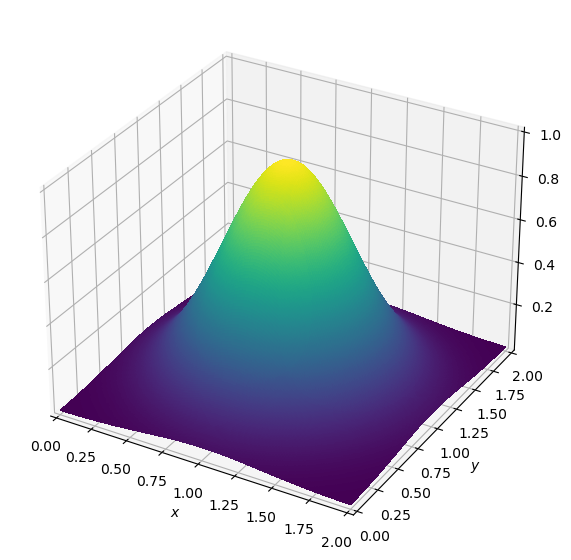

In [1]:
from examples.cfd import  plot_field
import numpy as np
from sympy import symbols
from devito import *
from AI4NS_Eq import Couple_PDE_Solver, coupling_eq
def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.001  # Timestep size (sigma=0.2)
c = 0.5  # Value for c
nx = 256
ny = 256
length = 1
dx = length/nx
dy = length/ny
extra_dim = Dimension(name='e')
# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length,length))
grid_p = Grid(shape=(2,nx, ny), extent=(length,length,length))

u = TimeFunction(name='u', grid=grid,time_order = 2, space_order = 2)
v = TimeFunction(name='v', grid=grid,time_order = 2, space_order = 2)
delta_p = TimeFunction(name='\Delta p', grid=grid,time_order = 2, space_order = 2)
delta_q = TimeFunction(name='\Delta q', grid=grid,time_order = 2, space_order = 2)
p = TimeFunction(name='p', grid=grid,time_order = 2, space_order = 2)
q = TimeFunction(name='q', grid=grid,time_order = 2, space_order = 2,dimensions=(u.indices[0],extra_dim, *u.indices[1:]),shape = (u.shape[0],2,*u.shape[1:]))

init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
init_smooth(field=v.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
q.data[:,0,:] = u.data[:]
q.data[:,1,:] = v.data[:]
plot_field(v.data[0])

In [2]:
delta = 1
D = 1
eq1 = Eq(q.dt + u*q.dx + v*q.dy + delta*q.forward - D*q.laplace, -(p.dx + p.dy))
eq2 = Eq(delta_p.laplace,-1/dt*(q.forward.dx + q.forward.dy))
eq3 = Eq(delta_q, -dt*(delta_p.dx+delta_p.dy))


In [3]:
eqs = [eq1,eq2,eq3]

In [4]:
eq1

Eq(u(t, x, y)*Derivative(q(t, e, x, y), x) + v(t, x, y)*Derivative(q(t, e, x, y), y) + q(t + dt, e, x, y) - Derivative(q(t, e, x, y), (x, 2)) - Derivative(q(t, e, x, y), (y, 2)) + Derivative(q(t, e, x, y), t), -Derivative(p(t, x, y), x) - Derivative(p(t, x, y), y))

In [5]:
eq2

Eq(Derivative(\Delta p(t, x, y), (x, 2)) + Derivative(\Delta p(t, x, y), (y, 2)), -1000.0*Derivative(q(t + dt, e, x, y), x) - 1000.0*Derivative(q(t + dt, e, x, y), y))

In [6]:
eq3

Eq(\Delta q(t, x, y), -0.001*Derivative(\Delta p(t, x, y), x) - 0.001*Derivative(\Delta p(t, x, y), y))

In [7]:
coupling_eq(eqs, [u,v,delta_p,delta_q,p,q], dt,dx,dy,[q,delta_p,delta_q])

Equation is not affine w.r.t the target, falling back to standardsympy.solve that may be slow


Eq((256.0*q(t + dt, e, x, y) - 256.0*q(t + dt, e, x, y - h_y))*v(t, x, y) + (256.0*q(t + dt, e, x, y) - 256.0*q(t + dt, e, x - h_x, y))*u(t, x, y) - 1000.0*q(t, e, x, y) + q(t + dt, e, x, y) + 1000.0*q(t + dt, e, x, y) + 131072.0*q(t + dt, e, x, y) + 131072.0*q(t + dt, e, x, y) - 65536.0*q(t + dt, e, x, y - h_y) - 65536.0*q(t + dt, e, x, y + h_y) - 65536.0*q(t + dt, e, x - h_x, y) - 65536.0*q(t + dt, e, x + h_x, y), -256.0*p(t + dt, x, y) - 256.0*p(t + dt, x, y) + 256.0*p(t + dt, x, y - h_y) + 256.0*p(t + dt, x - h_x, y))
Eq(-131072.0*\Delta p(t + dt, x, y) - 131072.0*\Delta p(t + dt, x, y) + 65536.0*\Delta p(t + dt, x, y - h_y) + 65536.0*\Delta p(t + dt, x, y + h_y) + 65536.0*\Delta p(t + dt, x - h_x, y) + 65536.0*\Delta p(t + dt, x + h_x, y), -1000.0*(256.0*q(t + dt, e, x, y) - 256.0*q(t + dt, e, x, y - h_y)) - 1000.0*(256.0*q(t + dt, e, x, y) - 256.0*q(t + dt, e, x - h_x, y)))


TypeError: devito.types.utils.DimensionTuple() argument after * must be an iterable, not int

In [8]:
solve(eq2, delta_p)


Equation is not affine w.r.t the target, falling back to standardsympy.solve that may be slow


500.0*(-1.0*h_x**2*h_y*q(t + dt, e, x, y) + 1.0*h_x**2*h_y*q(t + dt, e, x, y + h_y) + 0.001*h_x**2*\Delta p(t, x, y - h_y) + 0.001*h_x**2*\Delta p(t, x, y + h_y) - 1.0*h_x*h_y**2*q(t + dt, e, x, y) + 1.0*h_x*h_y**2*q(t + dt, e, x + h_x, y) + 0.001*h_y**2*\Delta p(t, x - h_x, y) + 0.001*h_y**2*\Delta p(t, x + h_x, y))/(h_x**2 + h_y**2)

In [ ]:
solve(eq)